# 02 — Reporting: plots y export a PDF

Creamos todo lo necesario que aparecía en Quick start para probar el reporte y los plots.

In [1]:
#Importación de librerías

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(context="notebook", style="whitegrid")
from mcport import PriceSeries, Portfolio, MonteCarloSimulation
from mcport.providers import YahooProvider

# --- Tickers de la cartera diversificada (USD) ---
symbols = ["AAPL", "NVDA", "XOM", "NEE", "LMT", "CAT"]

# Instancia del proveedor Yahoo
provider = YahooProvider()

# 3 años (~756 días hábiles)
dict_pricehistory = provider.price_history(symbols=symbols, periods=756)

#Creamos el diccionario de PriceSeries
price_series_dict = {}

for sym, df in dict_pricehistory.items():
    ps = PriceSeries.from_dataframe(
        symbol=sym,
        df=df,
        price_col="adj_close",
        currency="USD",
        provider="YahooFinance",
        asset_type="equity"
    )
    price_series_dict[sym] = ps


# --- Seleccionamos los PriceSeries del diccionario ---
positions = [
    price_series_dict["AAPL"],
    price_series_dict["NVDA"],
    price_series_dict["XOM"],
    price_series_dict["NEE"],
    price_series_dict["LMT"],
    price_series_dict["CAT"],
]

# --- Pesos según bloques temáticos ---
weights = [0.20, 0.20, 0.15, 0.15, 0.15, 0.15]

# --- Creamos la cartera ---
portfolio = Portfolio(
    positions=positions,
    weights=weights,
    name="Cartera_Diversificada",
    currency="USD"
)

# ----------------------------
# 1️⃣ Monte Carlo por activo
# ----------------------------

results_assets = {}
n_days = 126       # 6 meses ~ 126 días hábiles
n_sims = 2000
seed = 42

for sym, ps in price_series_dict.items():
    mc = MonteCarloSimulation(ps, days=n_days, n_sims=n_sims, seed=seed)
    res = mc.simulate_and_summarize()
    results_assets[sym] = res

# ----------------------------
# 2️⃣ Monte Carlo del Portfolio
# ----------------------------

mc_port = MonteCarloSimulation(
    portfolio, days=n_days, n_sims=n_sims, capital_inicial=1000.0, seed=seed
)
res_port = mc_port.simulate_and_summarize()


UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('O') and dtype('<m8[ns]')

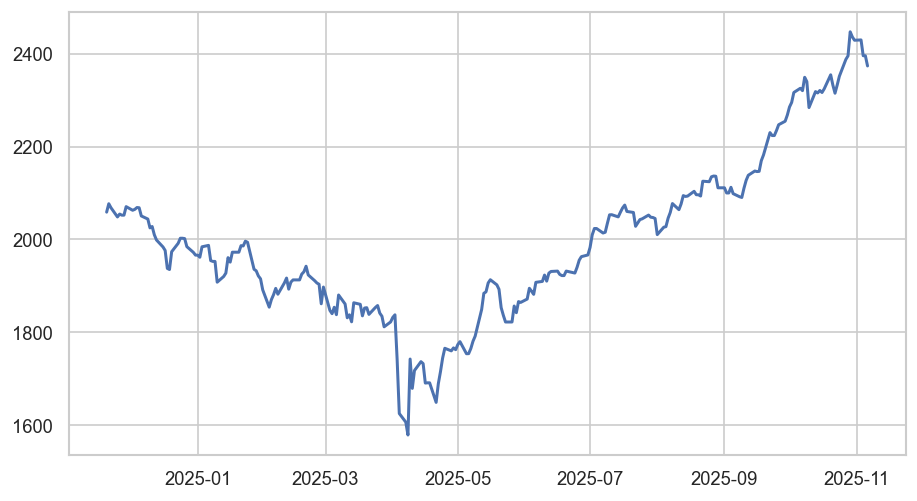

In [ ]:
# Secuencia end-to-end
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mcport.providers import YahooProvider
from mcport import PriceSeries, Portfolio, MonteCarloSimulation
from mcport.plot import (
    # PriceSeries / Portfolio
    plot_priceseries_history,
    plot_priceseries_drawdown,
    plot_priceseries_rolling_vol,
    plot_priceseries_rolling_return,
    plot_priceseries_returns_hist,
    plot_portfolio_equity,
    plot_portfolio_drawdown,
    plot_portfolio_weights,
    plot_portfolio_corr_heatmap,
    # Monte Carlo
    plot_mc_paths,
    plot_mc_fan,
    plot_mc_overlay_with_history,
    plot_mc_terminal_hist,
    plot_mc_terminal_cdf,
)
from mcport.reports import PortfolioReporter, PDFReportConfig

# -------------------------------
# 0) Rutas de salida
# -------------------------------
fig_dir = Path("plot")
pdf_dir = Path("reports")
fig_dir.mkdir(parents=True, exist_ok=True)
pdf_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------
# 1) Datos y objetos
# -------------------------------
symbols = ["AAPL", "NVDA", "XOM", "NEE", "LMT", "CAT"]
provider = YahooProvider()
dict_pricehistory = provider.price_history(symbols=symbols, periods=756)  # ~3 años hábiles

price_series_dict = {}
for sym, df in dict_pricehistory.items():
    ps = PriceSeries.from_dataframe(
        symbol=sym,
        df=df,
        price_col="adj_close",        # ajusta si tu provider usa otro nombre
        currency="USD",
        provider="YahooFinance",
        asset_type="equity",
    )
    price_series_dict[sym] = ps

positions = [price_series_dict[s] for s in symbols]
weights   = [0.20, 0.20, 0.15, 0.15, 0.15, 0.15]

portfolio = Portfolio(
    positions=positions,
    weights=weights,
    name="Cartera_Diversificada",
    currency="USD",
)

# -------------------------------
# 2) Monte Carlo
# -------------------------------
n_days = 126
n_sims = 2000
seed   = 42

# Por activo
mc_assets_values = {}
for sym, ps in price_series_dict.items():
    mc = MonteCarloSimulation(ps, days=n_days, n_sims=n_sims, seed=seed)
    out = mc.simulate_and_summarize()
    mc_assets_values[sym] = out["valores"]  # (n_sims, T+1)

# Por cartera
mc_port = MonteCarloSimulation(
    portfolio, days=n_days, n_sims=n_sims, capital_inicial=1000.0, seed=seed
)
mc_port_out   = mc_port.simulate_and_summarize()
mc_values_port = mc_port_out["valores"]

# -------------------------------
# 3) Figuras: PriceSeries
# -------------------------------
for sym, ps in price_series_dict.items():
    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_priceseries_history(ps, ax=ax, show=False)
    fig.savefig(fig_dir / f"{sym}_history.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_priceseries_drawdown(ps, ax=ax, show=False)
    fig.savefig(fig_dir / f"{sym}_drawdown.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_priceseries_rolling_vol(ps, window=20, ax=ax, show=False)
    fig.savefig(fig_dir / f"{sym}_rolling_vol_20.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_priceseries_rolling_return(ps, window=63, ax=ax, show=False)
    fig.savefig(fig_dir / f"{sym}_rolling_ret_63.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_priceseries_returns_hist(ps, bins=50, ax=ax, show=False)
    fig.savefig(fig_dir / f"{sym}_returns_hist.png", bbox_inches="tight"); plt.close(fig)

# -------------------------------
# 4) Figuras: Portfolio
# -------------------------------
fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_portfolio_equity(portfolio, initial_capital=1.0, ax=ax, show=False)
fig.savefig(fig_dir / f"{portfolio.name}_equity.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_portfolio_drawdown(portfolio, initial_capital=1.0, ax=ax, show=False)
fig.savefig(fig_dir / f"{portfolio.name}_drawdown.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(8, 6), dpi=120); ax = fig.add_subplot(111)
plot_portfolio_weights(portfolio, ax=ax, show=False)
fig.savefig(fig_dir / f"{portfolio.name}_weights.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(7.2, 6.4), dpi=120); ax = fig.add_subplot(111)
plot_portfolio_corr_heatmap(portfolio, ax=ax, show=False)
fig.savefig(fig_dir / f"{portfolio.name}_corr.png", bbox_inches="tight"); plt.close(fig)

# -------------------------------
# 5) Figuras: Monte Carlo (por activo)
# -------------------------------
for sym, values in mc_assets_values.items():
    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_mc_paths(values, n_show=100, ax=ax, show=False, title=f"Monte Carlo — {sym} (sample paths)")
    fig.savefig(fig_dir / f"{sym}_mc_paths.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_mc_fan(values, ax=ax, show=False, title=f"Monte Carlo — {sym} (percentile fan)")
    fig.savefig(fig_dir / f"{sym}_mc_fan.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_mc_terminal_hist(values, ax=ax, show=False, title=f"Monte Carlo — {sym} (terminal distribution)")
    fig.savefig(fig_dir / f"{sym}_mc_terminal_hist.png", bbox_inches="tight"); plt.close(fig)

    fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
    plot_mc_terminal_cdf(values, ax=ax, show=False, title=f"Monte Carlo — {sym} (terminal CDF)")
    fig.savefig(fig_dir / f"{sym}_mc_terminal_cdf.png", bbox_inches="tight"); plt.close(fig)

# -------------------------------
# 6) Figuras: Monte Carlo (cartera)
# -------------------------------
eq_hist = portfolio.value_series(initial_capital=mc_port_out["summary"]["capital_inicial"])

fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_mc_overlay_with_history(
    history=eq_hist,
    values=mc_values_port,
    ax=ax,
    show=False,
    title=f"Historical + MC — {portfolio.name}",
    last_n_history=252,
    n_show=100,
)
fig.savefig(fig_dir / f"{portfolio.name}_mc_overlay.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_mc_fan(mc_values_port, ax=ax, show=False, title=f"Monte Carlo — {portfolio.name} (percentile fan)")
fig.savefig(fig_dir / f"{portfolio.name}_mc_fan.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_mc_paths(mc_values_port, n_show=120, ax=ax, show=False, title=f"Monte Carlo — {portfolio.name} (sample paths)")
fig.savefig(fig_dir / f"{portfolio.name}_mc_paths.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_mc_terminal_hist(mc_values_port, ax=ax, show=False, title=f"Monte Carlo — {portfolio.name} (terminal distribution)")
fig.savefig(fig_dir / f"{portfolio.name}_mc_terminal_hist.png", bbox_inches="tight"); plt.close(fig)

fig = plt.figure(figsize=(9, 4.8), dpi=120); ax = fig.add_subplot(111)
plot_mc_terminal_cdf(mc_values_port, ax=ax, show=False, title=f"Monte Carlo — {portfolio.name} (terminal CDF)")
fig.savefig(fig_dir / f"{portfolio.name}_mc_terminal_cdf.png", bbox_inches="tight"); plt.close(fig)

# -------------------------------
# 7) PDF completo (reports.py)
# -------------------------------
pdf_path = pdf_dir / f"{portfolio.name}_report.pdf"
cfg = PDFReportConfig(
    include_component_plots=True,
    include_corr_heatmap=True,
    include_weights=True,
    include_returns_hist=True,
    rolling_vol_window=20,
    rolling_ret_window=63,
    do_montecarlo=True,
    mc_days=n_days,
    mc_sims=n_sims,
    mc_seed=seed,
    mc_show_paths=120,
    mc_overlay_history_days=252,
)

reporter = PortfolioReporter(portfolio, str(pdf_path), cfg)
_ = reporter.build()  # sin prints
